# ZfNet

# I) Summary

**DISCLAIMER**:
- We will use the weights/biases of a pretained model from this [github repository](https://github.com/osmr/imgclsmob/tree/master/pytorch).
- We are only going to implement 1st version of ZFNet.
- We will remove Local Response Normalization.

--- 

- The paper [Visualizing and Understanding Convolutional Networks](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) introduces the notion of **Deconvnet** which enables us to **visualize
each layer**. 


- By **visualizing each layer**, we can get **more insight** about **what the model is learning** and thus, make some **adjustements** to make it more **optimize**.


- That's how **ZFnet** was created, an **AlexNet fine-tuned version based on visualization results**.

---

ZFNet architecture:

- **5 Convolutional layers**.
- **3 Fully connected layers**.
- **3 Overlapping Max pooling layers**.
- **ReLU** as activation function for hidden layer.
- **Softmax** as activation function for output layer.
- **60,000,000** trainable parameters.
- **Cross-entropy** as cost function
- **Mini-batch gradient descent with Momentum optimizer**.
- **Local Response Normalization** (Removing it seems to give better results)
  
---

ZFNet differences:

- 1st version: 
    - **Conv1** filters: Change from **(11x11 stride 4)** to **(7x7 stride 2)**.
       - By using **ZFNet**, top-5 validation error rate is **16.5%**.
       - By using **AlexNet**, top-5 validation error rate is **18.2%**.


- 2nd version:
    - **Conv2** filters: Use of **512** filters instead of **384**.
    - **Conv4** filters: Use of **1024** filters instead of **384**.
    - **Conv5** filters: Use of **512** filters instead of **256**.
        - By using **ZFnet**, top-5 validation error rate is **16.0%**.
        - By using **AlexNe**t, top-5 validation error rate is **18.2%**.

![legend](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/zfnet/1.png)
![zfnet-model](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/zfnet/2.png)

# II) Implementation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchsummary import summary
import os
from zipfile import ZipFile
import urllib.request
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from collections import OrderedDict
from classes import class_names
from utils import *

## a) Architecture build

In [2]:
class ZFNet(nn.Module):
    
    def __init__(self):
        super(ZFNet, self).__init__()
        
        # CONV PART.
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1)),
            ('act1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)),
            ('conv2', nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=0)),
            ('act2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)),
            ('conv3', nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)),
            ('act3', nn.ReLU()),
            ('conv4', nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)),
            ('act4', nn.ReLU()),
            ('conv5', nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)),
            ('act5', nn.ReLU()),
            ('pool5', nn.MaxPool2d(kernel_size=3, stride=2, padding=0, return_indices=True))
        ]))
    
        self.feature_outputs = [0]*len(self.features)
        self.switch_indices = dict()
        self.sizes = dict()


        self.classifier = nn.Sequential(OrderedDict([
            ('fc6', nn.Linear(9216, 4096)),
            ('act6', nn.ReLU()),
            ('fc7', nn.Linear(4096, 4096)),
            ('act7', nn.ReLU()),
            ('fc8', nn.Linear(4096, 1000))
        ]))
    
        # DECONV PART.
        self.deconv_pool5 = nn.MaxUnpool2d(kernel_size=3,
                                           stride=2,
                                           padding=0)
        self.deconv_act5 = nn.ReLU()
        self.deconv_conv5 = nn.ConvTranspose2d(256,
                                               384,
                                               kernel_size=3,
                                               stride=1,
                                               padding=1,
                                               bias=False)
        
        self.deconv_act4 = nn.ReLU()
        self.deconv_conv4 = nn.ConvTranspose2d(384,
                                               384,
                                               kernel_size=3,
                                               stride=1,
                                               padding=1,
                                               bias=False)
        
        self.deconv_act3 = nn.ReLU()
        self.deconv_conv3 = nn.ConvTranspose2d(384,
                                               256,
                                               kernel_size=3,
                                               stride=1,
                                               padding=1,
                                               bias=False)
        
        self.deconv_pool2 = nn.MaxUnpool2d(kernel_size=3,
                                           stride=2,
                                           padding=1)
        self.deconv_act2 = nn.ReLU()
        self.deconv_conv2 = nn.ConvTranspose2d(256,
                                               96,
                                               kernel_size=5,
                                               stride=2,
                                               padding=0,
                                               bias=False)
        
        self.deconv_pool1 = nn.MaxUnpool2d(kernel_size=3,
                                           stride=2,
                                           padding=1)
        self.deconv_act1 = nn.ReLU()
        self.deconv_conv1 = nn.ConvTranspose2d(96,
                                               3,
                                               kernel_size=7,
                                               stride=2,
                                               padding=1,
                                               bias=False)
        
    def forward(self, x):
        
        for i, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, indices = layer(x)
                self.feature_outputs[i] = x
                self.switch_indices[i] = indices
            else:
                x = layer(x)
                self.feature_outputs[i] = x
            
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def forward_deconv(self, x, layer):
        if layer < 1 or layer > 5:
            raise Exception("ZFnet -> forward_deconv(): layer value should be between [1, 5]")
        
        x = self.deconv_pool5(x,
                              self.switch_indices[12],
                              output_size=self.feature_outputs[-2].shape[-2:])
        x = self.deconv_act5(x)
        x = self.deconv_conv5(x)
        
        if layer == 1:
            return x
        
        x = self.deconv_act4(x)
        x = self.deconv_conv4(x)
        
        if layer == 2:
            return x
        
        x = self.deconv_act3(x)
        x = self.deconv_conv3(x)
        
        if layer == 3:
            return x
        
        x = self.deconv_pool2(x,
                              self.switch_indices[5],
                              output_size=self.feature_outputs[4].shape[-2:])
        x = self.deconv_act2(x)
        x = self.deconv_conv2(x)
     
        if layer == 4:
            return x
        
        x = self.deconv_pool1(x,
                              self.switch_indices[2],
                              output_size=self.feature_outputs[1].shape[-2:])
        x = self.deconv_act1(x)
        x = self.deconv_conv1(x)
        
        if layer == 5:
            return x

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ZFNet()
#model.cuda()
model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 110, 110]          14,208
              ReLU-2         [-1, 96, 110, 110]               0
         MaxPool2d-3  [[-1, 96, 55, 55], [-1, 96, 55, 55]]               0
            Conv2d-4          [-1, 256, 26, 26]         614,656
              ReLU-5          [-1, 256, 26, 26]               0
         MaxPool2d-6  [[-1, 256, 13, 13], [-1, 256, 13, 13]]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13  [[-1, 256, 6, 6], [-1, 256, 6, 6]]               0
      

## b) Loading pretrained model

The pretrained model was trained on ImageNet-1K dataset over 140 epoch.  
This model obtains a top-1 accuracy 39.79% and a top-5 accuracy 17.27% on the validation set.
To get more information about the training phase, check the [log file](./zfnet.log).

Put `zfnet-1727-d010ddca.pth.zip` file to current directory.

In [14]:
# Download pretrained model.
#urllib.request.urlretrieve('https://github.com/osmr/imgclsmob/releases/download/v0.0.395/zfnet-1727-d010ddca.pth.zip',
#                           'zfnet-1727-d010ddca.pth.zip')

# Unzip 'zfnet-1727-d010ddca.pth.zip'.
with ZipFile('zfnet-1727-d010ddca.pth.zip', 'r') as zip_ref:
    zip_ref.extractall()
    
# Load pretrained model parameters into our model.
load_model('zfnet-1727-d010ddca.pth', model)

# Delete 'zfnet-1727-d010ddca.pth' and 'zfnet-1727-d010ddca.pth.zip'.
os.remove('zfnet-1727-d010ddca.pth')
#os.remove('zfnet-1727-d010ddca.pth.zip')

## c) Testing

In [15]:
# Create a dataset.

class CustomDataset(Dataset):
    
    def __init__(self, transform = None):
        
        self.transform = transform
        self.imgs = []
        self.imgsToDisplay = []
        
        current_dir = os.getcwd()
        image_dir = os.path.join(current_dir, 'img/')
        img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
    
        for img in img_files:
            # Read image.
            img = cv2.imread(img)
            
            self.imgsToDisplay.append(img)
            
            # Apply transformations.
            if self.transform is not None:
                img = self.transform(img)
                
            self.imgs.append(img)
            
    def __getitem__(self, index):    
        return self.imgs[index]
        
    def __len__(self):
        return len(self.imgs)

In [16]:
# Apply preprocessing step on dataset.
transformations = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                           std = [0.229, 0.224, 0.225])
                                     ])

custom_dataset = CustomDataset(transform=transformations)
test_loader = DataLoader(dataset=custom_dataset,
                         batch_size=1)

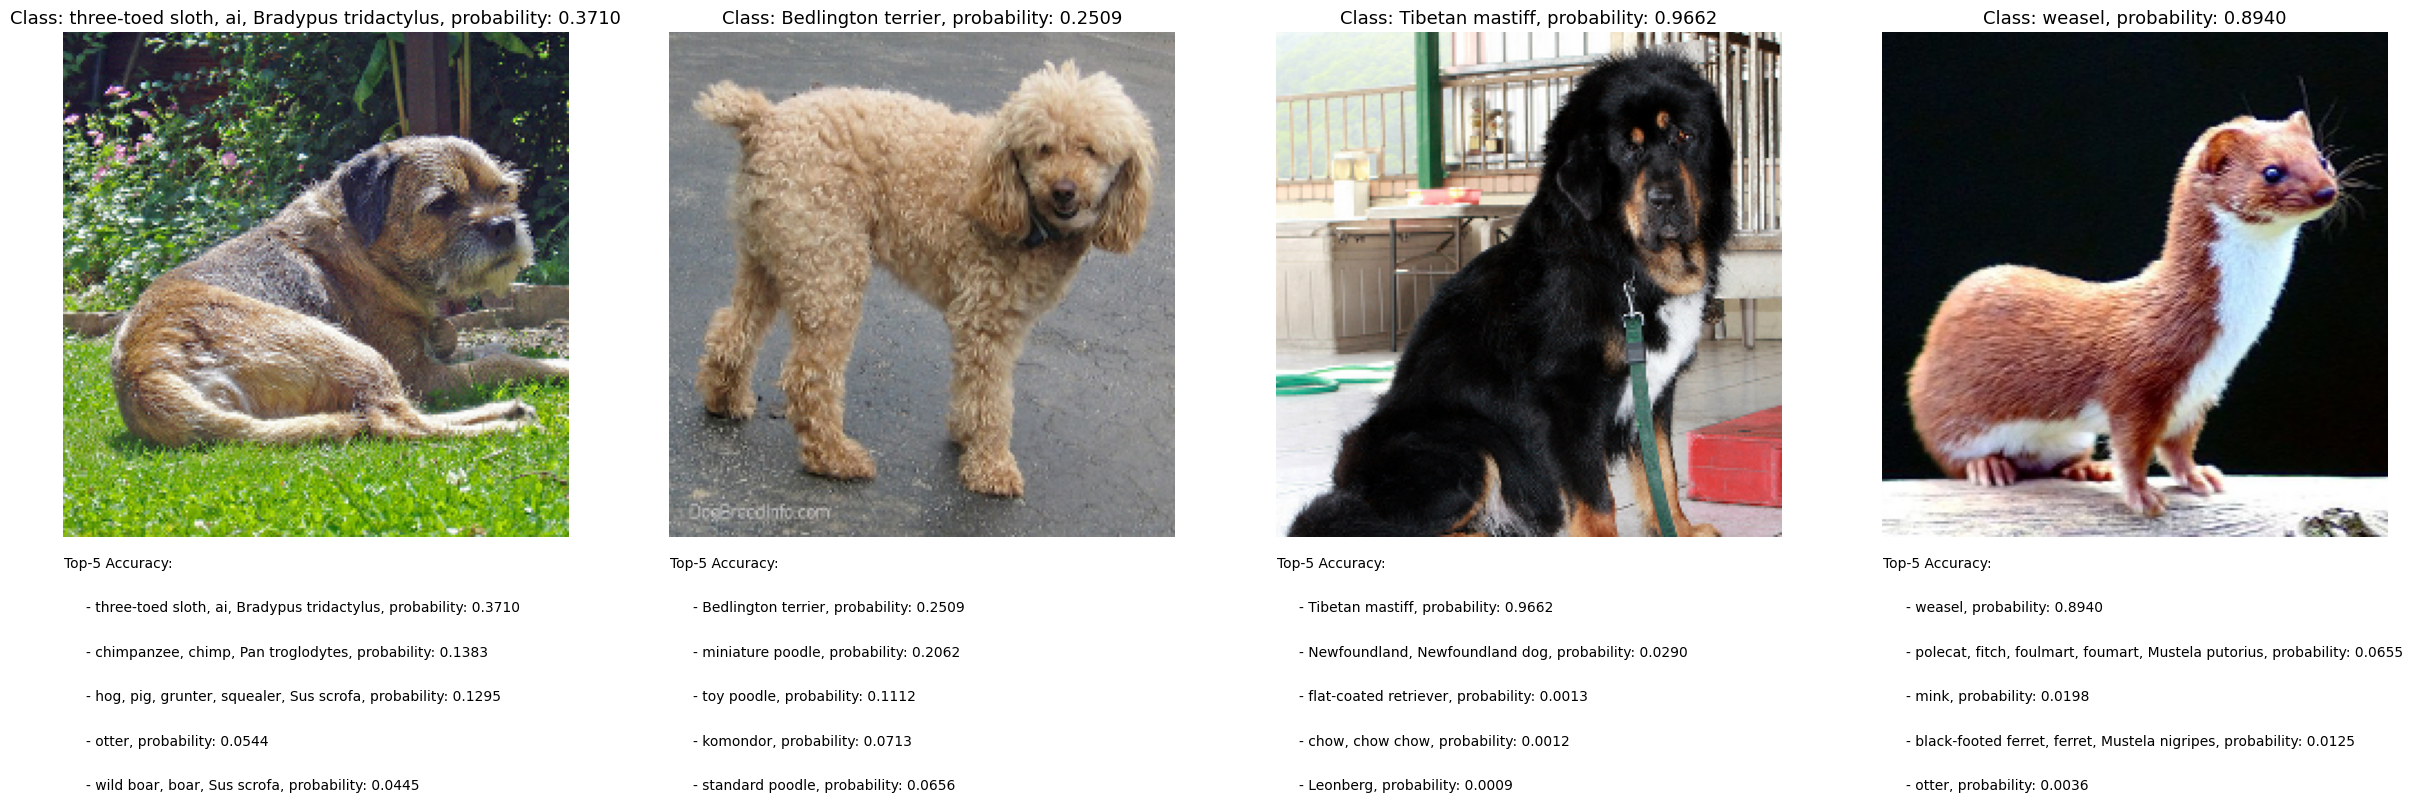

In [23]:
fig2 = plt.figure(figsize=(30,10))

model.eval()
with torch.no_grad():
    
    for i, image in enumerate(test_loader):
        #image = image.unsqueeze(0)  # 拓展维度, 拓展batch_size那一维
        probs = torch.nn.Softmax(dim=-1)(model(image.to(device)))
        
        probability, class_idx = torch.max(probs, 1)
        class_name = class_names[class_idx]
         
        fig2.add_subplot(1,4,i+1)
        plt.imshow(cv2.cvtColor(custom_dataset.imgsToDisplay[i], cv2.COLOR_BGR2RGB))
        plt.title("Class: " + class_name + ", probability: %.4f" % probability, fontsize=13)
        plt.axis('off')

        plt.text(0, 240, 'Top-5 Accuracy:')
        x, y = 10, 260
        
        for idx in np.argsort(probs.cpu().numpy())[0][-5::][::-1]:
            s = '- {}, probability: {:.4f}'.format(class_names[idx], probs[0, idx])
            plt.text(x, y, s=s, fontsize=10)
            y += 20
        print()

## d) Visualization of each layer

To visualize each layer, we need to reconstruct an approximate version of the picture. 
To do so, we first need to feed our main convnet with an image so that it can record the location of the local max in each pooling region (called switches)

Then, the switches are then used in the unpooling layer to map back pixels to input space.

![](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/zfnet/3.png)

Using DeconvNet, here is what the convnet sees at every layer.

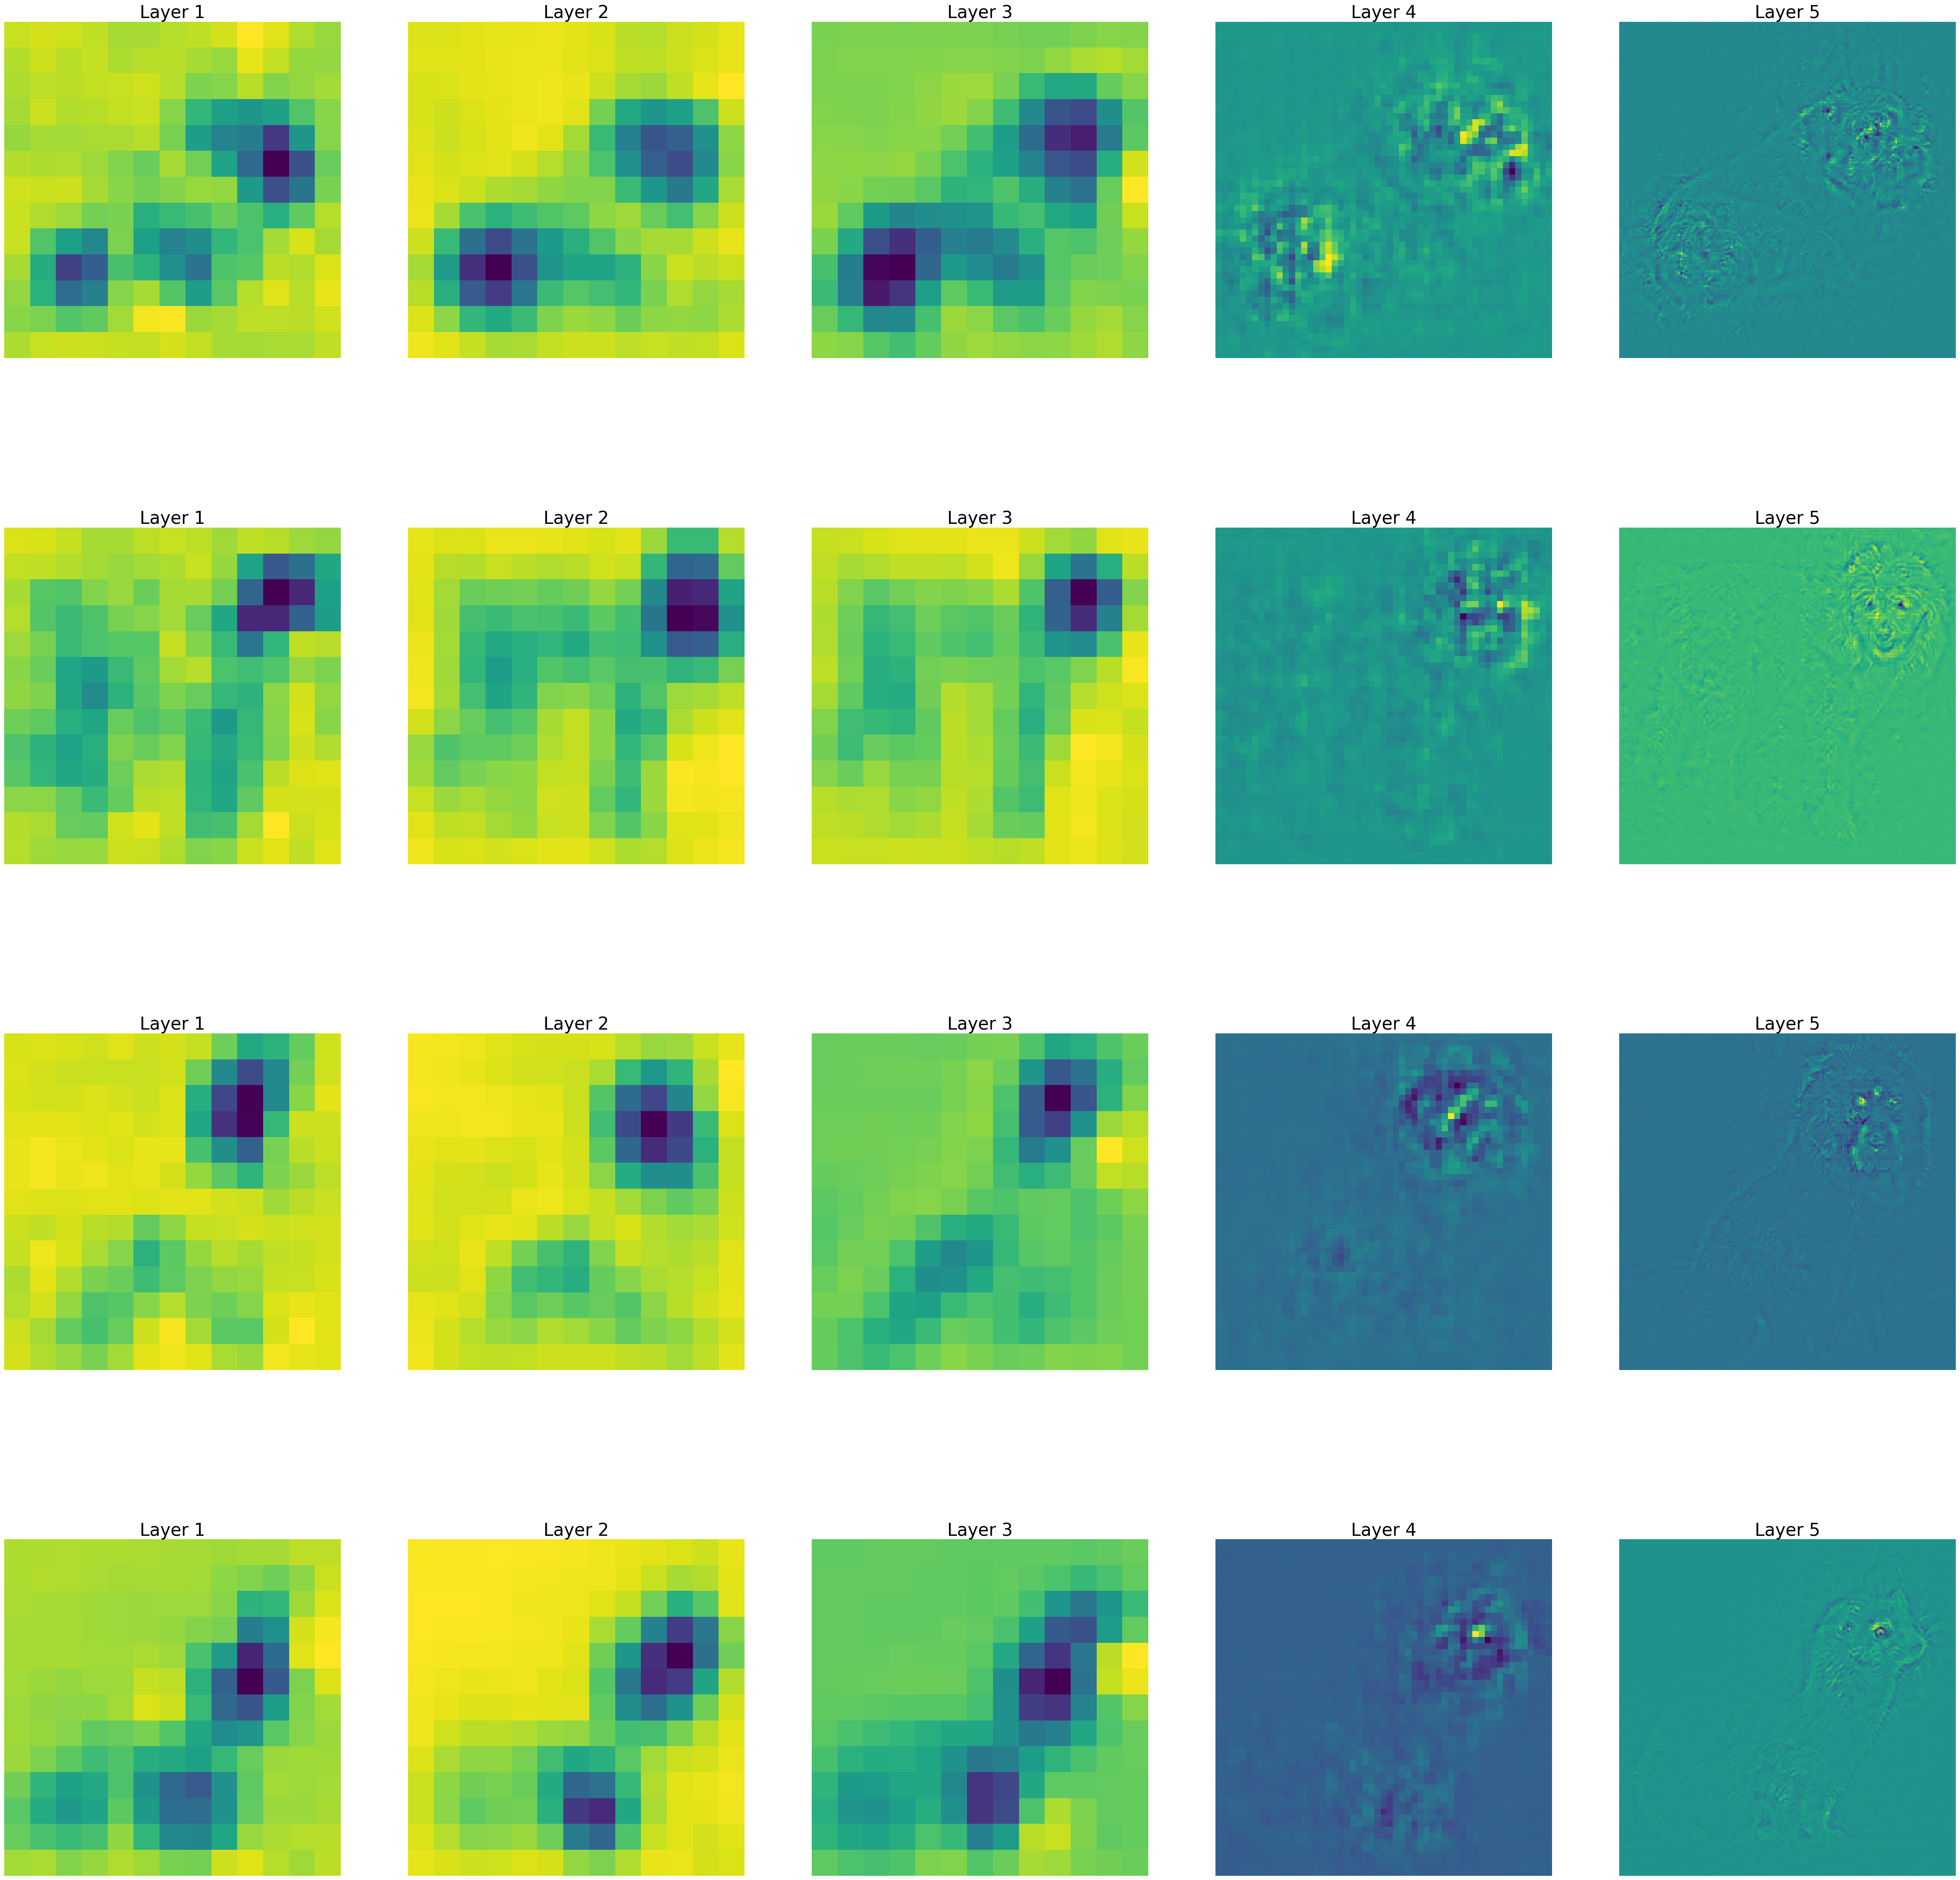

In [30]:
fig2 = plt.figure(figsize=(60,60))

model.eval()
count = 0
with torch.no_grad():
    for i, image in enumerate(test_loader):
        probs = torch.nn.Softmax(dim=-1)(model(image.to(device)))
        for j in range(1,6):
            count += 1
            ax = fig2.add_subplot(4,5, count)
            ax.set_title("Layer {}".format(j), fontsize= 30)
            plt.axis('off')
            # Channel 3 of the image.
            plt.imshow(model.forward_deconv(model.feature_outputs[12], j).detach().cpu().numpy()[0, 2, :])

End